# Import necessary libraries

In [2]:
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.document_loaders import Docx2txtLoader
import os

In [3]:

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [4]:
import openai
openai.api_key = os.environ['OPENAI_API_KEY']

# Load file

In [5]:
document_path = "../data/Evaluation Sets/Robinson Advisory.docx"
loader = Docx2txtLoader(document_path)
documents = loader.load()

In [6]:
documents

[Document(page_content='- 2-\n\n\n\nADVISORY SERVICES AGREEMENT\n\n\n\nThis Advisory Services Agreement is entered into as of June 15th, 2023 (the “Effective Date”), by and between Cloud Investments Ltd., ID 51-426526-3, an Israeli company (the "Company"), and Mr. Jack Robinson, Passport Number 780055578, residing at 1 Rabin st, Tel Aviv, Israel, Email: jackrobinson@gmail.com ("Advisor").\n\n\n\nWhereas,\tAdvisor has expertise and/or knowledge and/or relationships, which are relevant to the Company’s business and the Company has asked Advisor to provide it with certain Advisory services, as described in this Agreement; and\n\nWhereas, \tAdvisor has agreed to provide the Company with such services, subject to the terms set forth in this Agreement.\n\n\n\nNOW THEREFORE THE PARTIES AGREE AS FOLLOWS:\n\n\n\nServices:  \n\nAdvisor shall provide to the Company, as an independent contractor, software development services, and / or any other services as agreed by the parties from time to time 

# Segmenting the document into segments:

In [ ]:
text_splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

In [8]:
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=0)
# texts = text_splitter.split_documents(documents)

In [9]:
embeddings = OpenAIEmbeddings()
docsearch = Chroma.from_documents(texts, embeddings)

/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


# Retrieval Chains:

In [10]:
retriever=docsearch.as_retriever(search_kwargs={"k": 1})

In [11]:
query = "What is the termination notice?"
docs = retriever.get_relevant_documents(query)
print(docs)

[Document(page_content='Termination: Either party, at any given time, may terminate this Agreement, for any reason whatsoever, with or without cause, upon fourteen (14) days’ prior written notice. Notwithstanding the above, the Company may terminate this Agreement immediately and without prior notice if Advisor refuses or is unable to perform the Services, or is in breach of any provision of this Agreement.', metadata={'source': '../data/Evaluation Sets/Robinson Advisory.docx'})]


In [12]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=retriever)


/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [13]:
query = "What is the termination notice?"
qa.run(query) 


/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


"\n\nThe termination notice is fourteen (14) days' prior written notice."

In [14]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [15]:

query = "What is the termination notice?"
docs = retriever.get_relevant_documents(query)
pretty_print_docs(docs)



Document 1:

Termination: Either party, at any given time, may terminate this Agreement, for any reason whatsoever, with or without cause, upon fourteen (14) days’ prior written notice. Notwithstanding the above, the Company may terminate this Agreement immediately and without prior notice if Advisor refuses or is unable to perform the Services, or is in breach of any provision of this Agreement.


In [16]:
response = qa.run(query)
response

" The termination notice is fourteen (14) days' prior written notice."

# RAGAS

In [17]:
json_file="../Context/context.json"


In [19]:
import json

json_file = "../evaluation_data/robinson_context.json"


with open(json_file, "r") as f:
    data = json.load(f)

questions, ground_truth = [], []

for item in data:
    if "question" in item:  # Check if "question" key exists
        questions.append(item["question"])
    if "answer" in item:  # Check if "answer" key exists
        ground_truth.append(item["answer"])

print("Questions:")
for question in questions:
    print(question)

print("\nGround Truth:")
for answer in ground_truth:
    print(answer)


Questions:
WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ARE THEIR DEFINED NAMES?
WHAT IS THE TERMINATION NOTICE?
What are the payments to the Advisor under the Agreement?

Ground Truth:
CLOUD INVESTMENTS LTD. ("COMPANY") AND JACK ROBINSON ("ADVISOR")
According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot perform the Services or is in breach of any provision of this Agreement.
According to section 6: 1. Fees of $9 per hour up to a monthly limit of $1,500, 2. Workspace expense of $100 per month, 3. Other reasonable and actual expenses if approved by the company in writing and in advance.


In [20]:
import json

json_file = "../evaluation_data/robinson_context.json"  # Replace with your actual path

with open(json_file, "r") as f:
    data = json.load(f)

questions = []  # List to store extracted questions
for item in data:
    if "question" in item:
        questions.append(item["question"])


In [21]:
context = []
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = retriever.get_relevant_documents(processed_question)

    # Extract and store only page_content
    context.extend([doc.page_content for doc in relevant_docs])

# Now the context list contains only page_content strings
print(context)


['Whereas, \tAdvisor has agreed to provide the Company with such services, subject to the terms set forth in this Agreement.\n\nNOW THEREFORE THE PARTIES AGREE AS FOLLOWS:\n\nServices:', 'Termination: Either party, at any given time, may terminate this Agreement, for any reason whatsoever, with or without cause, upon fourteen (14) days’ prior written notice. Notwithstanding the above, the Company may terminate this Agreement immediately and without prior notice if Advisor refuses or is unable to perform the Services, or is in breach of any provision of this Agreement.', 'As full and sole consideration for the Services, and subject to the performance of the Services, the Company shall pay the Advisor, against an invoice provided to the Company by Advisor, hourly fees at a rate of USD 9 (nine) per Billable Hour as defined below, limited to a maximum of USD 1,500 per month (the "Fees"). In addition, the Company shall pay the advisor USD 100 per month to finance a workspace for the Advisor

In [22]:
# context = []
# for question in questions:
#     # Preprocess question (e.g., lowercase, remove punctuation)
#     processed_question = question.lower().strip()

#     # Call retriever function with processed question
#     relevant_docs = retriever.get_relevant_documents(processed_question)
#     context.extend(relevant_docs)
#     # pretty_print_docs(relevant_docs)
# context

   


In [23]:
answers = []  # Create an empty list to store answers for each question
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question and context (if needed)
    answer = qa.run(processed_question)  # Include context if necessary

    # Append answer to the answers list
    answers.append(answer)

answers  # This will print a list of answers for each question


[' The parties to the agreement are the Advisor (who is agreeing to provide services) and the Company (who is receiving the services). Their defined names are not explicitly stated in the given context.',
 " Fourteen (14) days' prior written notice.",
 ' The payments to the advisor under the agreement are hourly fees at a rate of USD 9 per Billable Hour and a monthly payment of USD 100 for workspace expenses.']

In [24]:
print(type(answers))

<class 'list'>


In [25]:
context_lists = []

for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = retriever.get_relevant_documents(processed_question)

    # Create a new list for this question's context
    context_for_question = []

    # Extract and store only page_content (assuming Document has a page_content attribute)
    context_for_question.extend([doc.page_content for doc in relevant_docs])

    # Append the question's context list with only page_content to the main list
    context_lists.append(context_for_question)

# Now context_lists contains lists of page_content strings for each question

context_lists



[['Whereas, \tAdvisor has agreed to provide the Company with such services, subject to the terms set forth in this Agreement.\n\nNOW THEREFORE THE PARTIES AGREE AS FOLLOWS:\n\nServices:'],
 ['Termination: Either party, at any given time, may terminate this Agreement, for any reason whatsoever, with or without cause, upon fourteen (14) days’ prior written notice. Notwithstanding the above, the Company may terminate this Agreement immediately and without prior notice if Advisor refuses or is unable to perform the Services, or is in breach of any provision of this Agreement.'],
 ['As full and sole consideration for the Services, and subject to the performance of the Services, the Company shall pay the Advisor, against an invoice provided to the Company by Advisor, hourly fees at a rate of USD 9 (nine) per Billable Hour as defined below, limited to a maximum of USD 1,500 per month (the "Fees"). In addition, the Company shall pay the advisor USD 100 per month to finance a workspace for the 

In [26]:
ground_truths_lists = [[item] for item in ground_truth]

# Print the modified list of lists
print("Ground Truths (List of Lists):")
for sublist in ground_truths_lists:
    print(sublist)

Ground Truths (List of Lists):
['CLOUD INVESTMENTS LTD. ("COMPANY") AND JACK ROBINSON ("ADVISOR")']
['According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot perform the Services or is in breach of any provision of this Agreement.']
['According to section 6: 1. Fees of $9 per hour up to a monthly limit of $1,500, 2. Workspace expense of $100 per month, 3. Other reasonable and actual expenses if approved by the company in writing and in advance.']


In [27]:
print(type(ground_truths_lists))

<class 'list'>


In [28]:
from datasets import Dataset
data = {
    "question": questions, # list 
    "answer": answers, # list
    "contexts": context_lists, # list list
    "ground_truths": ground_truths_lists # list Lists
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluation

In [29]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        
    ],
)

df = result.to_pandas()

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


In [30]:
df

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ...,The parties to the agreement are the Advisor ...,"[Whereas, \tAdvisor has agreed to provide the ...","[CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK R...","CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK RO...",1.0,1.000000,NaN,0.934947
1,WHAT IS THE TERMINATION NOTICE?,Fourteen (14) days' prior written notice.,"[Termination: Either party, at any given time,...",[According to section 4: 14 days for convenien...,According to section 4: 14 days for convenienc...,1.0,0.500000,1.0,0.866186
2,What are the payments to the Advisor under the...,The payments to the advisor under the agreeme...,[As full and sole consideration for the Servic...,[According to section 6: 1. Fees of $9 per hou...,According to section 6: 1. Fees of $9 per hour...,1.0,0.666667,1.0,0.990389



## Visualisation

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_82137/3395980989.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 800x600 with 0 Axes>

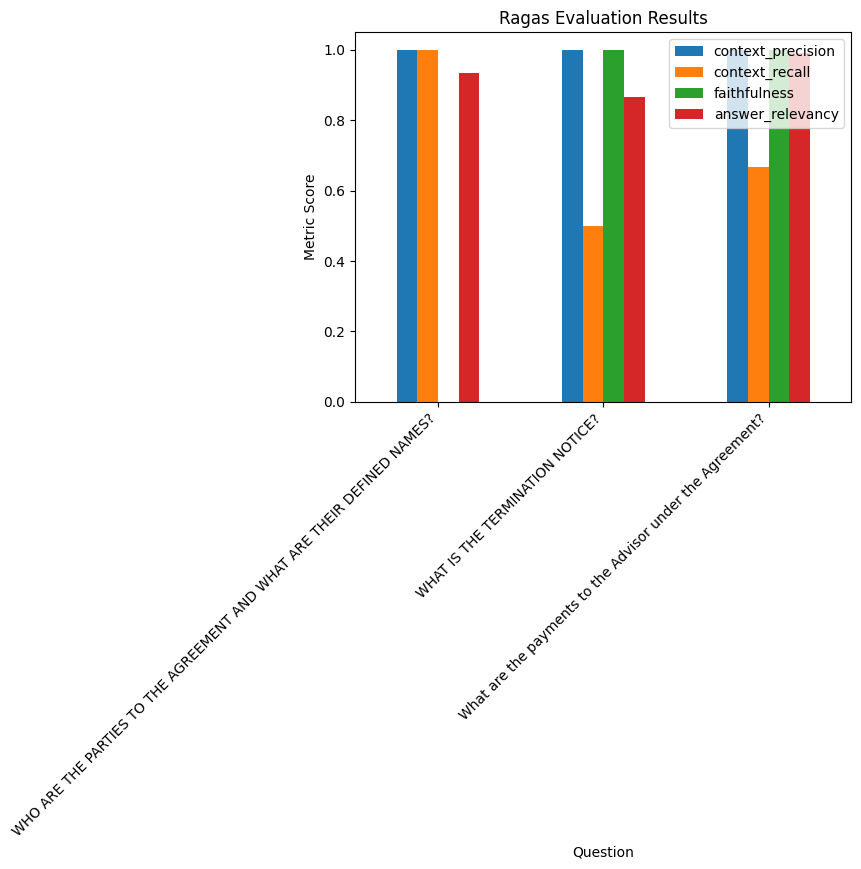

In [32]:
import pandas as pd
import matplotlib.pyplot as plt


# Create the bar chart:
plt.figure(figsize=(8, 6))
df.plot(kind='bar', x='question', y=['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy'])
plt.xlabel('Question')
plt.ylabel('Metric Score')
plt.title('Ragas Evaluation Results')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

